# Reading and writing ParFlow binary files with Python 

ParFlow Binary (pfb) files are the primary file format that is written by ParFlow and we use for inputs to the model. It is a specialized binary file format that includes informaiton about our ParFlow grid and which is designed to be read and written very efficiently in paralle (something that is critically important for larger models that run on many processors).

You can find all the details about the pfb file format [here](https://parflow.readthedocs.io/en/latest/files.html#parflow-binary-files-pfb). Note that in general we have one variable per file in our ParFlow outputs. However there is an option for single file output with clm  (set with the [Solver.CLM.DailyRST](https://parflow.readthedocs.io/en/latest/keys.html?highlight=clm%20singlefile#clm-solver-parameters) key) that will combine all CLM outputs into a single output file. These files will be named with `.C.pfb` file extension. 

This notebook walks through several examples of reading and writing pfb files using outputs from the Little Washita exercises. For this to work you will need to run the exercises and have outputs first.  You can learn more about reading and writing pfb files you can also chedk out the tutorial in the manual [here](https://parflow.readthedocs.io/en/latest/python/tutorials/pfb.html).

This notebook includes the following examples:
 - Example 1: Reading in a single pfb to a numpy array
 - Example 2: Reading in a series of pfbs to a numpy array
 - Example 3: Reading in run information by loading a run object from a pfidb file
 - Example 4: Writing a pfb file from a numpy array

### Import Packages
Here we will be using the reading and writing tools that come with the ParFlow tools package.  

In [1]:
import xarray as xr
import numpy as np
import os
from glob import glob
import matplotlib.pyplot as plt

import parflow as pf
from parflow.tools.fs import get_absolute_path
from parflow.tools.io import write_pfb, read_pfb
from parflow import Run

#setting the directory name that we will read our outputs from
run_name = 'LW_CLM'
run_dir = get_absolute_path(f'outputs/{run_name}')

#### Example 1:  Reading a single pfb file
For our first test we will just read in a single pressure file output using the `read_pfb` function. 

This will return a numpy array with dimensions [nz, ny, nx]

The ordering of this array follows ParFlow convention with the bottom layer lower left hand corner as index [0,0,0]. 

NOTE: this is flipped from the typical python y-axis ordering becuase grabbing [:,0,:] will give you the bottom (or southernmost) row of the domain. 

Also note that NA values in ParFlow are assigned a very large negative number  (i.e.-3.4e38) you will want to be sure to adjust for these in your plotting and analysis. 

Dimensions of output file: (10, 32, 64)


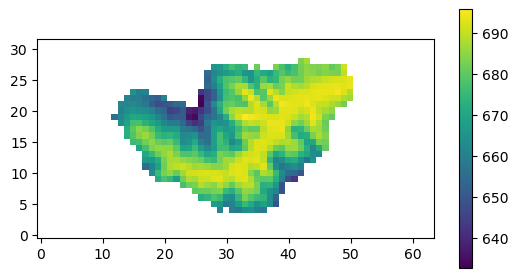

In [2]:
file_name = f'{run_name}.out.press.00002.pfb'
test_data = read_pfb(os.path.join(run_dir, file_name))

print(f'Dimensions of output file: {test_data.shape}')

#replace the large negative values with NAs
test_data[test_data< (-1e38)]= np.nan

# plot the bottom layer of the file we read in just to see what it looks like
# Note we flip the y axis here
plt.imshow(test_data[0,:,:])
plt.gca().invert_yaxis()
plt.colorbar(shrink=0.7)
plt.show()

####  Example 2: Reading a set of run outputs
ParFlow outputs files are named as follows `{runanme}.out.{variable_name}.{%05dtimestepnumber}.pfb`. Instead of pointing to individual files we can point to series of files for a given output variabe. 

This will give us a numpy array like with our last call but there will be an added dimension of time so the output will be [nt, nz, ny, nx] where nt is the number of timesteps that your model has written out. 

(73, 10, 32, 64)


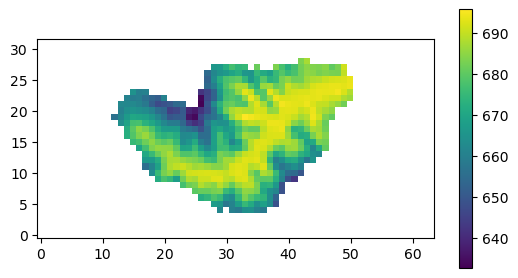

In [3]:
# First we'll get a list of the output pressure file names
files = glob(f'{run_dir}/*out.press*.pfb')

# Then we can read them in all at once like this
test_series = pf.read_pfb_sequence(files)

# Now if we print the shape of this well see that the first dimension 
# is the number of timesteps we wrote out 
print(test_series.shape)


# Once again just to check we can replace the NA values and plot up a single timestep of one layer
# just to see what it looks like. Note, once again we flip the y axis here
test_series[test_series< (-1e38)]= np.nan
plt.imshow(test_series[1,0,:,:])
plt.gca().invert_yaxis()
plt.colorbar(shrink=0.7)
plt.show()

####  Example 3: Reading in all the information about a run from the pfidb using the data accessor
Another handy thing you might want to do is read in all the information associated with your run so you have things like parameters and run dimensions handy for analysis. 

To do that we can (1) load a run object from the ParFlow Database that we wrote out when we created the run and then (2) use the `data_accesor` to pull out things we are interested in that are associated with the run. 

You can find details of everything available through the `data_accessor` [here](https://parflow.readthedocs.io/en/latest/python/tutorials/data_accessor.html). 

Also note that once you have the run loaded you can access any of the keys that were set in your pfb using the following syntax `run.{key_name}`

Solver: Field BinaryOutDir is not part of the expected schema <class 'parflow.tools.database.generated.Solver'>
  - nc
  - nr
  - nt
  - sw_ini
  - qflx_tran_vegm
  - scalez
  - hkdepth
  - wtfact
  - trsmx0
  - smpmax
  - pondmx
  - sdep
  - manning
  - rout
  - cout
  - sovout
Layer thickness values (dz): [1.0e+03 1.0e+02 5.0e+01 2.5e+01 1.0e+01 5.0e+00 1.0e+00 6.0e-01 3.0e-01
 1.0e-01]
4.4e-06


/opt/conda/lib/python3.11/site-packages/parflow/tools/io.py:1300: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_name, delim_whitespace=True, skiprows=2, header=None)


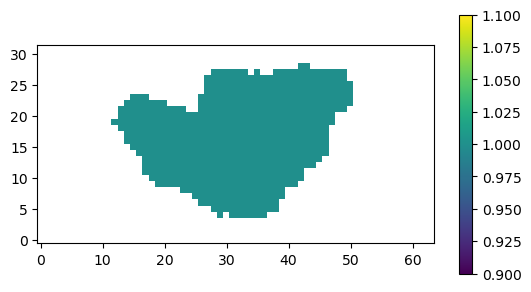

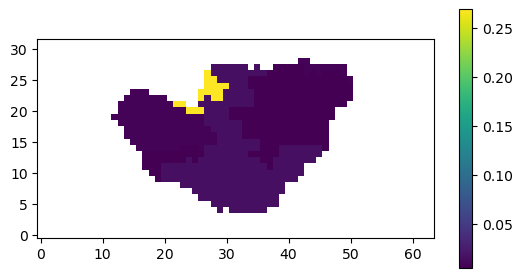

In [4]:
run = Run.from_definition(f'{run_dir}/{run_name}.pfidb')
data = run.data_accessor
print(data)

#you can get out individual properties with the data accessor like this
print('Layer thickness values (dz):', data.dz)

#or you can grab out keys from the run object like this: 
print(run.Mannings.Geom.domain.Value)

# or you can grab out gridded fields that got created when you setup your model 
# For example the domain mask (the map of active grid cells)
mask = data.mask

# with a little formatting we can set this so the 0 values are NA and the active cells are all 1
nanmask=mask.copy()
nanmask[nanmask == 0] = 'NaN'
nanmask[nanmask > 0] = 1

plt.imshow(nanmask[0,:,:])
plt.gca().invert_yaxis()
plt.colorbar(shrink=0.7)
plt.show()

# We can do the same thing with permeability. And now that we have the mask, instead of 
# replacing the negative numbers with nans we can just multiply by the mask
perm_x = data.computed_permeability_x *nanmask
plt.imshow(perm_x[9,:,:])
plt.gca().invert_yaxis()
plt.colorbar(shrink=0.7)
plt.show()

#### Example 4: Writing pfb from python
This is a simple example of writing a pfb file from a numpy array (you can see the full API for this [here](https://parflow.readthedocs.io/en/latest/python/tutorials/pfb.html)).  By default this will set the origin of the doman to [0.0, 0.0, 0.0] and the resolution to [1.0, 1.0, 1.0]. 

You can also set the processor distribution of the file and distribute it, but by default the processor topology will be se to to [1,1,1]. By default it will also write the `.dist` file but you can turn this option off. 

In [7]:
# Create numpy array
FBx_data = np.ones((10, 20, 20))

# Write a pfb out with all the standard settings
out_file = os.path.join(run_dir, 'test.pfb')
write_pfb(out_file, FBx_data) 

# write a pfb out chaning the grid resolution, and turning off the dist file
out_file = os.path.join(run_dir, 'test2.pfb')
write_pfb(out_file, FBx_data, dx=100.0, dy=100.0, dz=10.0, dist=False) 